In [1]:
import os
import sys
import numpy as np
from chrmt_generator import TranscriptomeGenerator, TranscriptomePredictor
from chrmt_train import maximum_likelihood_loss
from tensorflow.keras.models import load_model
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import pandas as pd

RESOLUTION = 100
window_size = 41


Using TensorFlow backend.


In [2]:
# Prepare model to perform inference with
trained_model_path = "../Models/Run_Transcriptome_only_TSS_log10p1TPM_transcriptome_41_16_5_0.0.model-30.hdf5"
trained_model = load_model(trained_model_path)

# trained_model_path = "../Models/Run_Transcriptome_only_TSS_log10p1TPM_MLE_lr-4_transcriptome_41_16_5_0.0.model-30.hdf5"
# trained_model = load_model(trained_model_path, custom_objects={'maximum_likelihood_loss': maximum_likelihood_loss})

# trained_model_path = "../Models/Run_Transcriptome_genome_wide_log10p1TPM_MSE_transcriptome_41_16_5_0.0.model-100.hdf5"
# trained_model = load_model(trained_model_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Compute a true vs predicted spearman
test_generator = TranscriptomeGenerator(window_size,
                   1,
                   shuffle=False,
                   mode='testing',
                   masking_probability=0.0)

H3K27ac_max = []

np.set_printoptions(precision=3, suppress=True)
yTrue = []
yPred = []
for i in tqdm(range(2000)):

    X, Y = test_generator.__getitem__(i)

    H3K27ac_max.append(np.max(X[:, :, 2]))
    
    yPred_value = trained_model.predict(X)
#     print(yPred_value)
    yTrue.append(Y[0][0])
    yPred.append(yPred_value[0][0])
#     print(i, Y, yPred, np.asarray(yPred).shape, "\n")
# print(list(zip(yTrue, yPred)))

pc, _ = pearsonr(yTrue, yPred)
sc, _ = spearmanr(yTrue, yPred)
# print("Pearson =", round(pc, 3), "Spearman =", round(sc, 3))

plt.rcParams["figure.figsize"] = (20, 12)
plt.plot(yTrue, yPred, 'o', markersize=4, color='green')
plt.xlabel("True Normalized TPM", size=40)
plt.ylabel("Predicted Normalized TPM", size=40)
plt.xlim(-4, 4)
plt.ylim(-1, 1)
plt.title("Pearson = "+str(round(pc, 3))+" Spearman = "+str(round(sc, 3)), size=50)
plt.show()

In [ ]:
# Pre-compute the epigenetic features for a few exemplar genes
prediction_generator = TranscriptomePredictor(window_size,
                       1,
                       shuffle=False,
                       mode='testing',
                       masking_probability=0.0,
                       cell_type=0,
#                        chrom="chr2", start=int(136118149/RESOLUTION), strand="-")  # CXCR4
#                        chrom="chr2", start=int(136116243/100)+1, strand="-") # CXCR4 alternative
#                        chrom="chr9", start=int(99105113/RESOLUTION), strand="+")  # TGFBR1
#                        chrom="chr2", start=int(84905656/RESOLUTION), strand="+") # High expression gene in T01
#                        chrom="chr2", start=int(33513875/RESOLUTION), strand="+") # Low expression gene in T01
                         chrom="chr2", start=int(186694060/RESOLUTION), strand="+") # Medium expression gene in T01 
                                              
for i in range(1):
    X, Y = prediction_generator.__getitem__(i)
    print(X.shape, Y.shape)
    np.save("Medium.npy", X)

In [3]:
# Load Alan's H3K27ac p300 dataset
df_CXCR4 = pd.read_csv("../Data/CXCR4.tsv", sep="\t")
df_CXCR4_values = df_CXCR4[df_CXCR4['Position_wrt_TSS']!="Control"]
df_CXCR4_values["Position_wrt_TSS"] = pd.to_numeric(df_CXCR4_values["Position_wrt_TSS"], errors='coerce')/RESOLUTION

df_TGFBR1 = pd.read_csv("../Data/TGFBR1.tsv", sep="\t")
df_TGFBR1_values = df_TGFBR1[df_TGFBR1['Position_wrt_TSS']!="Control"]
df_TGFBR1_values["Position_wrt_TSS"] = pd.to_numeric(df_TGFBR1_values["Position_wrt_TSS"], errors='coerce')/RESOLUTION
df_TGFBR1_values

/export/home/users/sbatra/miniconda/yes/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/export/home/users/sbatra/miniconda/yes/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Position_wrt_TSS,Fold_Change
0,-19.69,1.724330
1,-19.69,1.381576
2,-19.69,1.180747
3,-19.69,1.312039
4,-19.69,1.198220
...,...,...
147,18.49,1.726966
148,18.49,1.093041
149,18.49,1.079456
150,18.49,1.100834


/export/home/users/sbatra/miniconda/yes/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


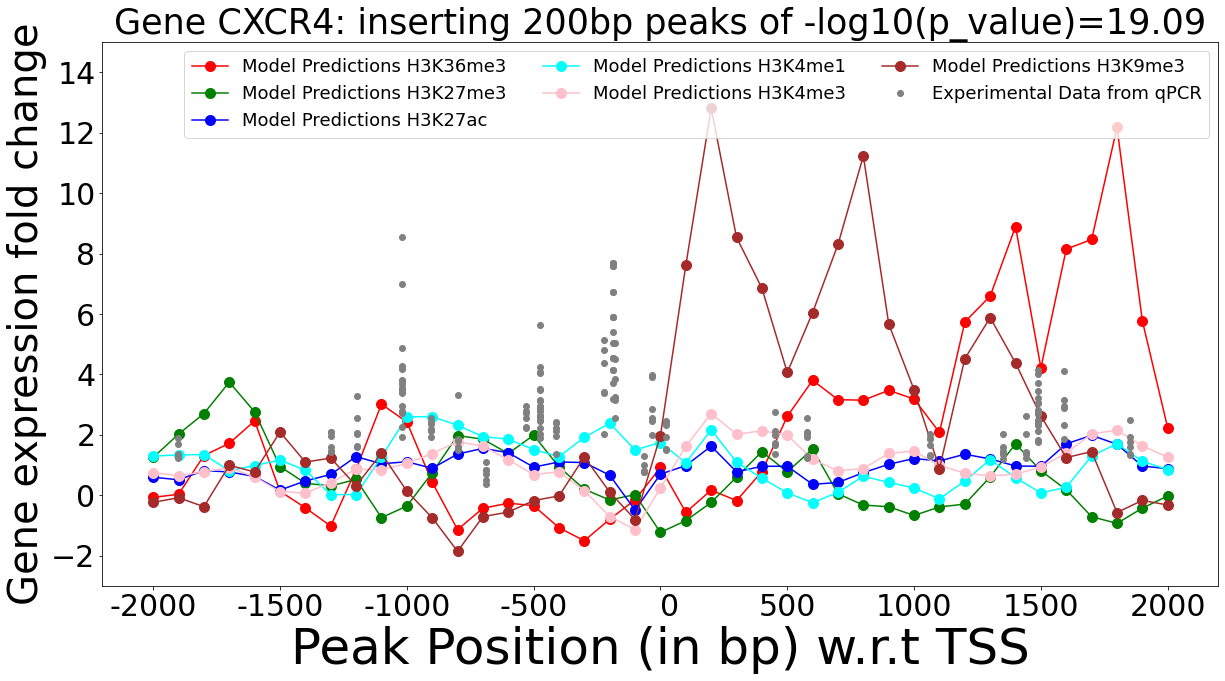

/export/home/users/sbatra/miniconda/yes/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


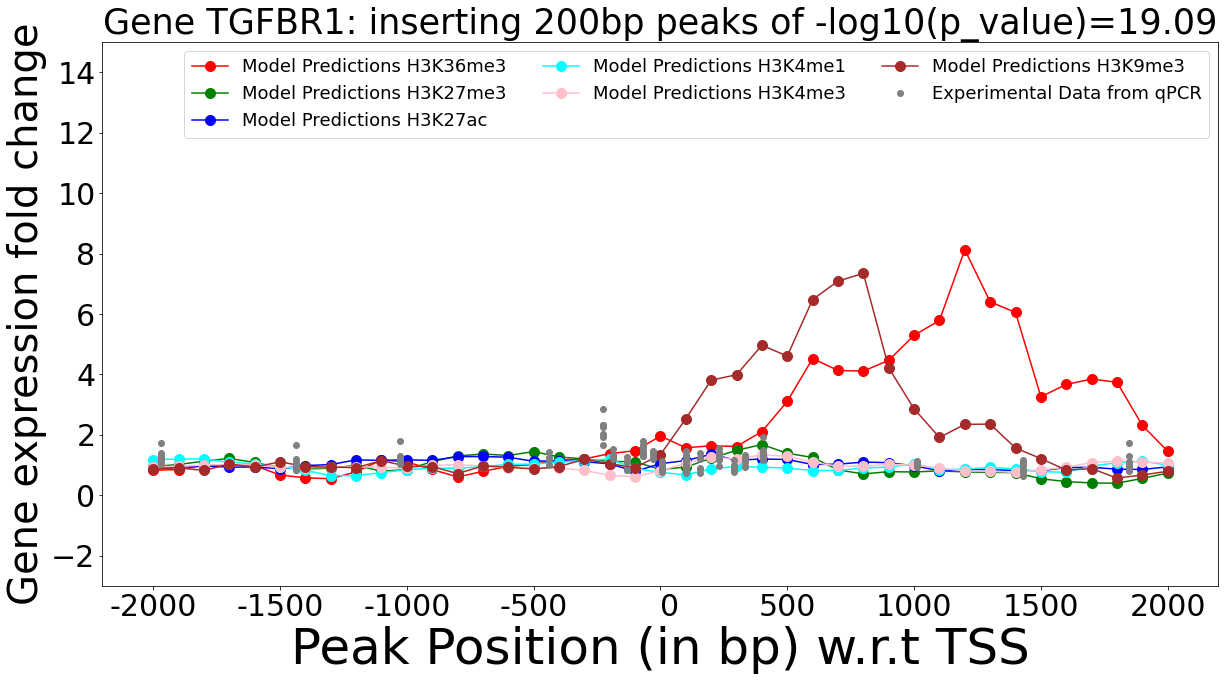

/export/home/users/sbatra/miniconda/yes/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


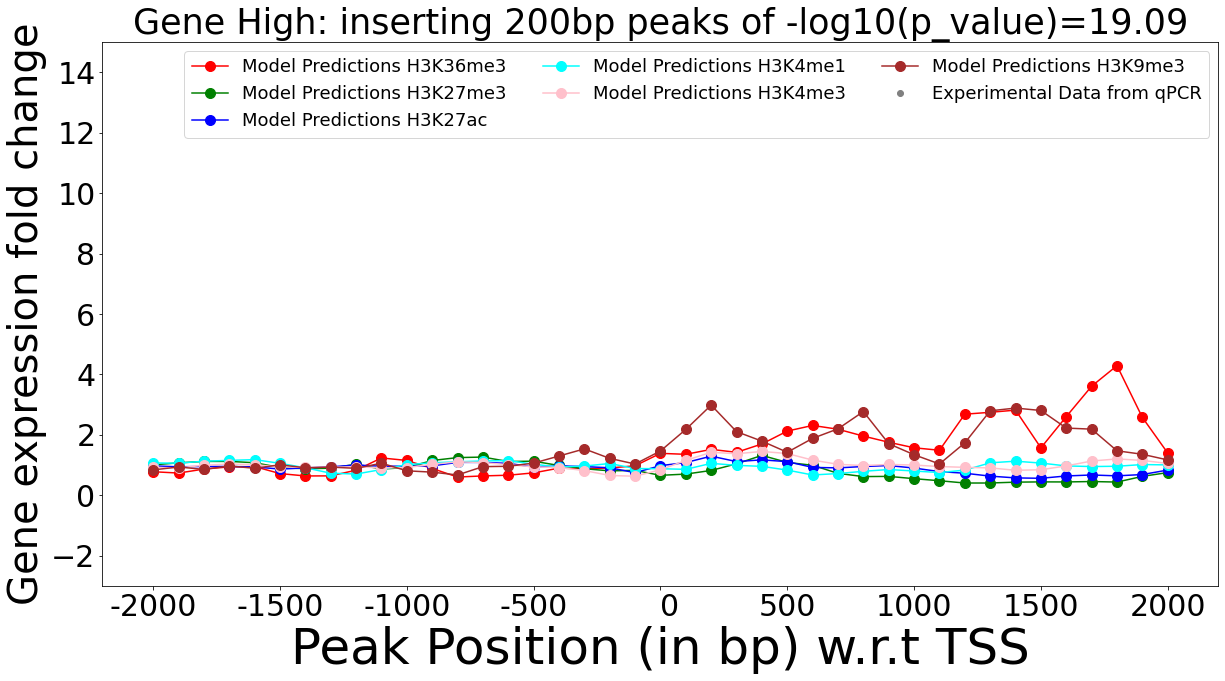

/export/home/users/sbatra/miniconda/yes/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


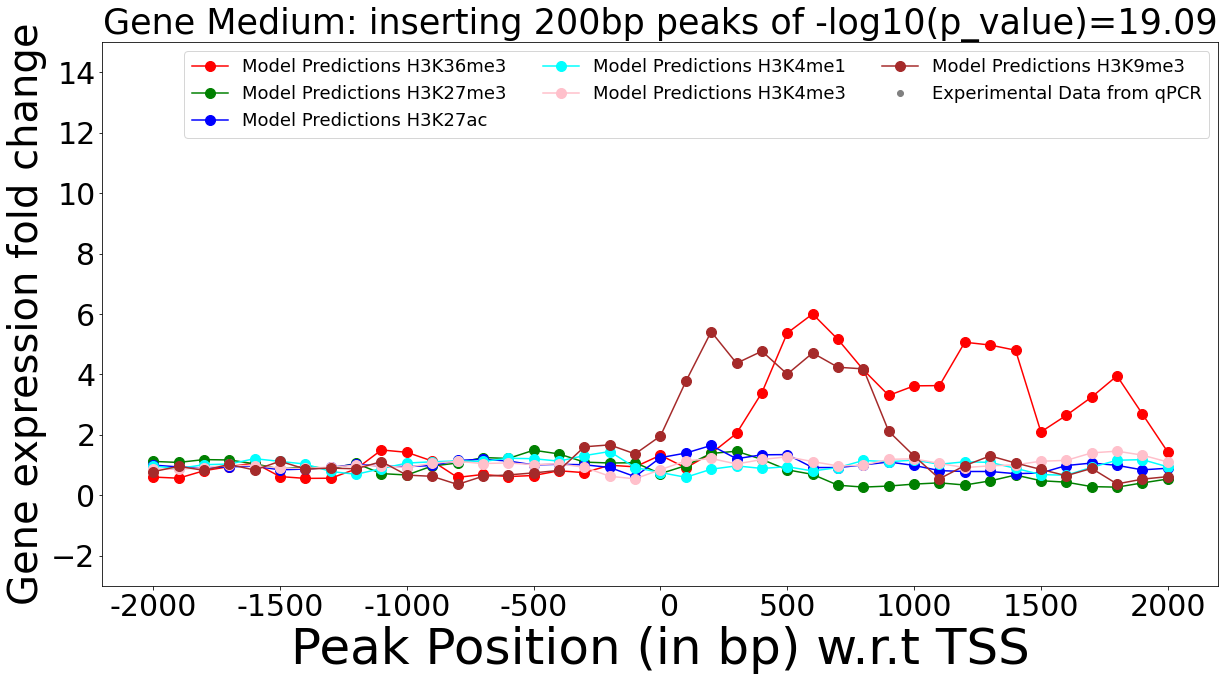

/export/home/users/sbatra/miniconda/yes/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


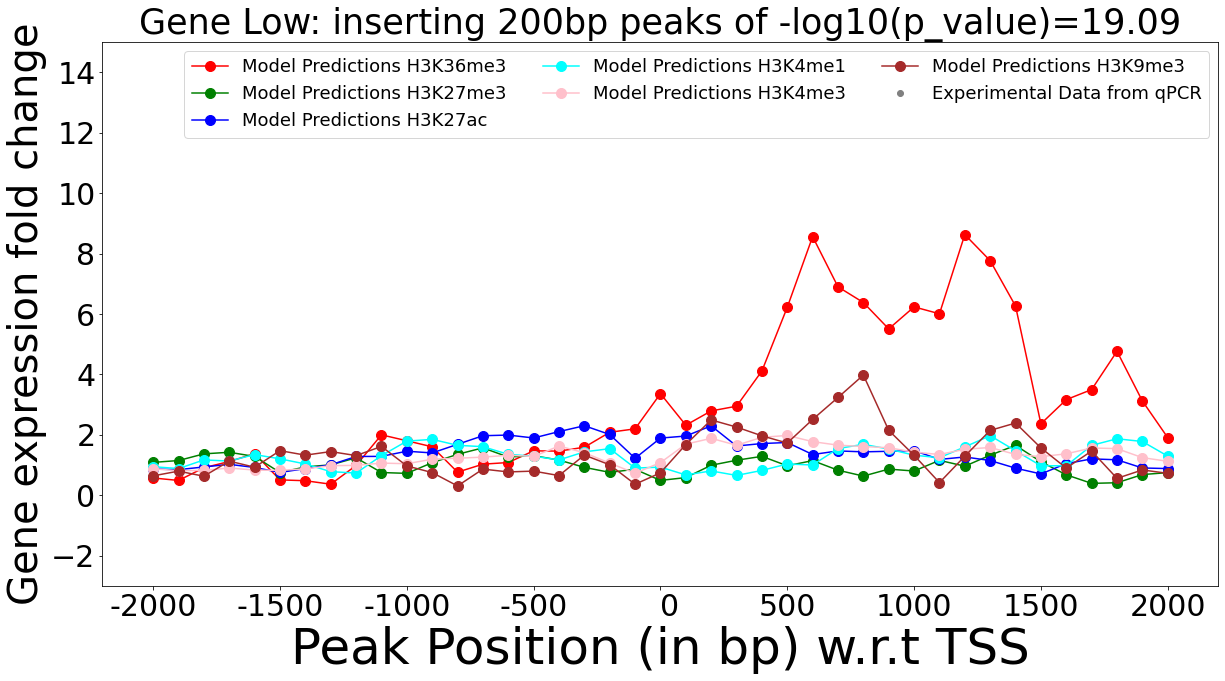

In [4]:
# Define in-silico epigenesis
def ise(gene, assay = 2, inserted_minuslog10p_value = 3, peak_width = 2):
    
    X = np.load(gene + ".npy")

    # Perform inference by introducing p-value changes with a peak width
    yPred = []
    center = window_size // 2
    positions = range(center - center, center + center + 1)
    for pos in positions:
        X_modified = np.copy(X)
        for p in range(pos - peak_width // 2, pos + peak_width // 2 + 1):
            if( (p>=0) and (p < max(positions)) ):
                X_modified[:, p, assay] = X_modified[:, p, assay] + inserted_minuslog10p_value
        yPred_value = trained_model.predict(X_modified)
        yy = yPred_value[0][0]
        yPred.append(yy)
    
    # Instead of scaling, divide by yPred
    yPred_value = trained_model.predict(X)[0][0]
    yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)

    return yPred


def p_value_mapping(inserted_minuslog10p_value):
    minuslog10p_value = np.expm1(inserted_minuslog10p_value)
    p_value = np.power(10, -1 * minuslog10p_value)
    return round(minuslog10p_value, 2)


def assay_name(assay):
    assays = ['H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K9me3']
    return assays[assay]


# Perform in-silico epigenesis
genes = ["CXCR4", "TGFBR1", "High", "Medium", "Low"]
assay_color = ['red', 'green', 'blue', 'cyan', 'pink', 'brown']
for gene in genes:

    for assay in range(6):

        if(gene == 'CXCR4'):
            df = df_CXCR4_values
        elif(gene == 'TGFBR1'):
            df = df_TGFBR1_values
        else:
            df = df_CXCR4_values.iloc[0:0,:].copy()

        inserted_minuslog10p_value = 3
        peak_width = 2
        gene_ise = ise(gene, assay, inserted_minuslog10p_value, peak_width)

        plt.rcParams["figure.figsize"] = (20, 10)
        plt.plot(range(-(window_size // 2), (window_size // 2) + 1), gene_ise, 'o-', color=assay_color[assay], markersize=10, label="Model Predictions " + assay_name(assay))
    plt.plot(df['Position_wrt_TSS'], df['Fold_Change'], 'o', color='gray', label="Experimental Data from qPCR")
    plt.xlim(-22, 22)
    plt.ylim(-3, 15)
    ax=plt.gca() 
    x_vals = ax.axes.get_xticks()
    ax.set_xticklabels(['{:3.0f}'.format(x * 100) for x in x_vals])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.tick_params(axis='both', which='minor', labelsize=30)
    plt.xlabel("Peak Position (in bp) w.r.t TSS", size=50)
    plt.ylabel("Gene expression fold change", size=40)
    plt.legend(loc=1, prop={'size': 18}, ncol=3)
    plt.title("Gene "+gene+": inserting " + str(peak_width * RESOLUTION) + "bp peaks of -log10(p_value)="+str(p_value_mapping(inserted_minuslog10p_value)), size=35)
    plt.show()
    plt.close()

In [ ]:
# Plot input epigenetic features and visualize them as a heatmap